# Building a table image to .csv pipeline

## Install libraries

In [1]:
%pip install transformers
%pip install pillow huggingface_hub
%pip install timm
%pip install matplotlib

## Table detection

What do you understand by table detection?

Definition: Given an image, finding the region of the table as a bounding box.

In [2]:
from huggingface_hub import hf_hub_download
from transformers import AutoImageProcessor, TableTransformerForObjectDetection
import torch
from PIL import Image
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
ROOT = '/content/drive/MyDrive/idp_bootcamp/week_3'
images_path = f'{ROOT}/assingment_data'

In [6]:
image_processor = AutoImageProcessor.from_pretrained("microsoft/table-transformer-detection")
model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/273 [00:00<?, ?B/s]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/table-transformer-detection were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [69]:
images = []
image_sizes = []
image_names = []

for filename in os.listdir(images_path):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(images_path, filename)
        image_names.append(filename.split('.')[0])
        image = Image.open(img_path).convert("RGB")
        images.append(image)
        image_sizes.append(image.size[::-1])

inputs = image_processor(images=images, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
target_sizes = torch.tensor(image_sizes)
results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)

In [8]:
print(results)

[{'scores': tensor([0.9998], grad_fn=<IndexBackward0>), 'labels': tensor([0]), 'boxes': tensor([[ 139.9236,  207.4321, 1072.2660,  739.9158]],
       grad_fn=<IndexBackward0>)}, {'scores': tensor([0.9998], grad_fn=<IndexBackward0>), 'labels': tensor([0]), 'boxes': tensor([[ 108.0275, 1345.3344,  993.7729, 1504.4559]],
       grad_fn=<IndexBackward0>)}, {'scores': tensor([0.9606], grad_fn=<IndexBackward0>), 'labels': tensor([0]), 'boxes': tensor([[ 163.4466,  379.1742, 1071.1254,  755.7567]],
       grad_fn=<IndexBackward0>)}, {'scores': tensor([0.9972], grad_fn=<IndexBackward0>), 'labels': tensor([0]), 'boxes': tensor([[227.3657, 425.9886, 884.2881, 946.6122]], grad_fn=<IndexBackward0>)}, {'scores': tensor([0.9997], grad_fn=<IndexBackward0>), 'labels': tensor([0]), 'boxes': tensor([[184.5348, 336.8719, 968.3674, 788.0457]], grad_fn=<IndexBackward0>)}, {'scores': tensor([0.9998], grad_fn=<IndexBackward0>), 'labels': tensor([0]), 'boxes': tensor([[131.0504, 132.8971, 913.1180, 321.4713]]

In [9]:
tables_dict = {}
for idx, result in enumerate(results):
  print(f"Results for Image {idx+1}:")
  tables_boxes = []
  for score, label, box in zip(result["scores"], result["labels"], result["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )
    tables_boxes.append(box)

  if tables_boxes != []:
    tables_dict[f'{idx}'] = tables_boxes

Results for Image 1:
Detected table with confidence 1.0 at location [139.92, 207.43, 1072.27, 739.92]
Results for Image 2:
Detected table with confidence 1.0 at location [108.03, 1345.33, 993.77, 1504.46]
Results for Image 3:
Detected table with confidence 0.961 at location [163.45, 379.17, 1071.13, 755.76]
Results for Image 4:
Detected table with confidence 0.997 at location [227.37, 425.99, 884.29, 946.61]
Results for Image 5:
Detected table with confidence 1.0 at location [184.53, 336.87, 968.37, 788.05]
Results for Image 6:
Detected table with confidence 1.0 at location [131.05, 132.9, 913.12, 321.47]
Results for Image 7:
Results for Image 8:
Detected table with confidence 1.0 at location [179.74, 174.84, 1084.94, 924.92]
Results for Image 9:
Results for Image 10:
Detected table with confidence 0.999 at location [293.15, 935.56, 767.59, 990.54]


In [10]:
tables_dict, images

({'0': [[139.92, 207.43, 1072.27, 739.92]],
  '1': [[108.03, 1345.33, 993.77, 1504.46]],
  '2': [[163.45, 379.17, 1071.13, 755.76]],
  '3': [[227.37, 425.99, 884.29, 946.61]],
  '4': [[184.53, 336.87, 968.37, 788.05]],
  '5': [[131.05, 132.9, 913.12, 321.47]],
  '7': [[179.74, 174.84, 1084.94, 924.92]],
  '9': [[293.15, 935.56, 767.59, 990.54]]},
 [<PIL.Image.Image image mode=RGB size=1222x1579>,
  <PIL.Image.Image image mode=RGB size=1224x1584>,
  <PIL.Image.Image image mode=RGB size=1234x1592>,
  <PIL.Image.Image image mode=RGB size=1226x1588>,
  <PIL.Image.Image image mode=RGB size=1237x1597>,
  <PIL.Image.Image image mode=RGB size=1224x1584>,
  <PIL.Image.Image image mode=RGB size=1224x1584>,
  <PIL.Image.Image image mode=RGB size=1224x1584>,
  <PIL.Image.Image image mode=RGB size=1224x1584>,
  <PIL.Image.Image image mode=RGB size=1224x1584>])

Let's visualise the table on the page image

In [11]:
from PIL import ImageDraw

def visualize_bbox(image, box, color="red", width=2):
  """
  Visualizes a bounding box on a PIL image.

  Args:
    image: A PIL Image object.
    box: A list or tuple of four integers representing the bounding box
         coordinates (xmin, ymin, xmax, ymax).
    color: The color of the bounding box (default: red).
    width: The width of the bounding box lines (default: 2).
  """

  draw = ImageDraw.Draw(image)
  draw.rectangle(box, outline=color, width=width)
  return image

In [12]:
for key in tables_dict.keys():
  for table_box in tables_dict[key]:
    idx = int(key)
    visualize_bbox(images[idx], table_box)
    break
  break

## Table structure recognition

What do you understand by table structure recognition?

Definition: Given an image of a table, identifying the rows, columns, and column headers.


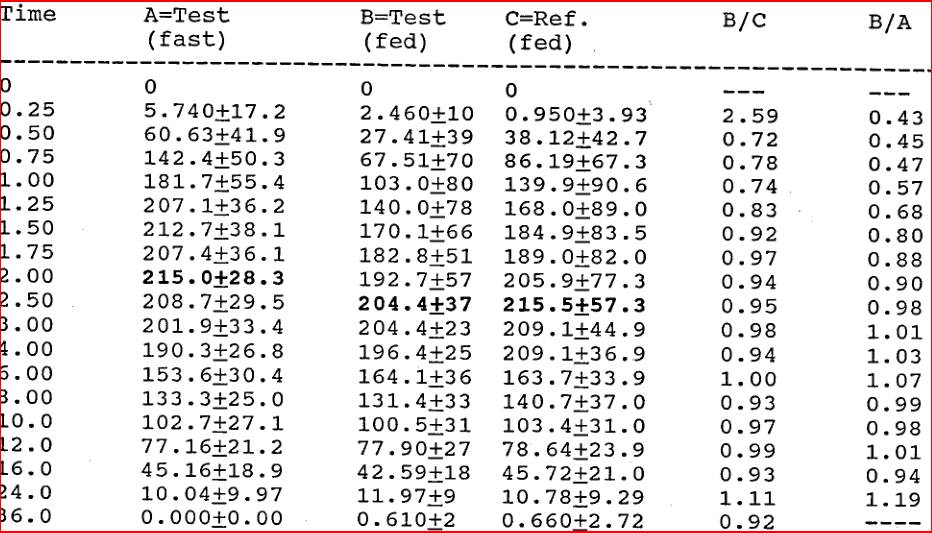

In [13]:
# Let's crop the table image from the page

table_image = images[0].crop(tables_dict['0'][0])

table_image

What's the problem with the above cropped table? Do you see any issues?

What can we do differently?

In [14]:
# Let's add some padding to the box so that we don't crop too close to the table.
padding = 10
table_images = []

for key in tables_dict.keys():
  for box in tables_dict[key]:
    idx = int(key)
    box = [box[0] - padding, box[1] - padding, box[2] + padding, box[3] + padding]
    table_images.append(images[idx].crop(box))

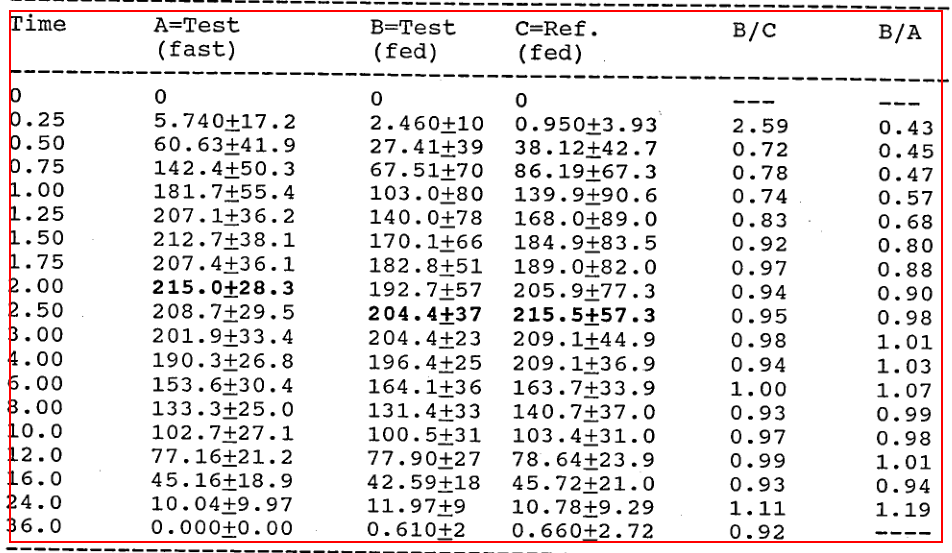

In [16]:
table_images[0]

Let's now do table structure recognition on the table image.

In [17]:
import matplotlib.pyplot as plt
from transformers import DetrFeatureExtractor, DetrForObjectDetection

In [19]:
COLORS = [
    [0.000, 0.447, 0.741],
    [0.850, 0.325, 0.098],
    [0.929, 0.694, 0.125],
    [0.494, 0.184, 0.556],
    [0.466, 0.674, 0.188],
    [0.301, 0.745, 0.933],
]

def plot_simple_box(table_img, bboxes, file_name="output.png"):
    plt.figure(figsize=(16, 10))
    plt.imshow(table_img)
    ax = plt.gca()
    colors = COLORS * 100
    for bbox, c in zip(bboxes, colors):
        ax.add_patch(
            plt.Rectangle(
                (bbox[0], bbox[1]),
                bbox[2] - bbox[0],
                bbox[3] - bbox[1],
                fill=False,
                color=c,
                linewidth=0.5,
            )
        )
    plt.axis("off")
    plt.show()
    plt.savefig(f"{file_name}.png", bbox_inches="tight")

In [20]:
model_structure = TableTransformerForObjectDetection.from_pretrained(
    "microsoft/table-transformer-structure-recognition")


def get_row_col_bounds(table, ts_thresh=0.7, plot=False):
    feature_extractor = DetrFeatureExtractor()
    table_encoding = feature_extractor(table, return_tensors="pt")

    # predict table structure
    with torch.no_grad():
        outputs = model_structure(**table_encoding)

    # visualize table structure
    target_sizes = [table.size[::-1]]
    table_struct_results = feature_extractor.post_process_object_detection(
        outputs, threshold=ts_thresh, target_sizes=target_sizes
    )[0]


    row_boxes = table_struct_results["boxes"][
        table_struct_results["labels"] == model_structure.config.label2id["table row"]
    ]

    row_scores = table_struct_results["scores"][
        table_struct_results["labels"] == model_structure.config.label2id["table row"]
    ]

    col_boxes = table_struct_results["boxes"][
        table_struct_results["labels"]
        == model_structure.config.label2id["table column"]
    ]

    col_scores = table_struct_results["scores"][
        table_struct_results["labels"]
        == model_structure.config.label2id["table column"]
    ]

    table_header_box = table_struct_results["boxes"][
        table_struct_results["labels"]
        == model_structure.config.label2id["table column header"]
    ]
    table_header_score = table_struct_results["scores"][
        table_struct_results["labels"]
        == model_structure.config.label2id["table column header"]
    ]

    print(f"Num rows initially detected: {len(row_boxes)}")
    print(f"Num cols initially detected: {len(col_boxes)}")
    print(f"Num table header detected: {len(table_header_box)}")


    return (
        row_boxes,
        row_scores,
        col_boxes,
        col_scores,
        table_header_box,
        table_header_score,
    )

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
table_structure_outs = []

for table_image in table_images:
  table_structure_out = get_row_col_bounds(table_image)
  table_structure_outs.append(table_structure_out)

/usr/local/lib/python3.10/dist-packages/transformers/models/detr/feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(


Num rows initially detected: 18
Num cols initially detected: 9
Num table header detected: 1
Num rows initially detected: 1
Num cols initially detected: 5
Num table header detected: 1
Num rows initially detected: 10
Num cols initially detected: 5
Num table header detected: 1
Num rows initially detected: 17
Num cols initially detected: 2
Num table header detected: 0
Num rows initially detected: 11
Num cols initially detected: 11
Num table header detected: 1
Num rows initially detected: 0
Num cols initially detected: 8
Num table header detected: 1
Num rows initially detected: 24
Num cols initially detected: 3
Num table header detected: 1
Num rows initially detected: 2
Num cols initially detected: 4
Num table header detected: 0


In [22]:
## can you identify each of these components?
table_structure_outs

[(tensor([[ 21.7732, 355.1626, 932.0540, 379.5815],
          [ 21.7204, 473.2265, 932.3958, 496.5269],
          [ 21.8957, 141.8683, 932.5552, 166.0789],
          [ 21.7976, 308.6233, 932.2280, 333.3215],
          [ 21.7479, 331.4420, 932.1908, 356.0956],
          [ 22.0899, 187.8318, 932.5544, 212.6864],
          [ 21.9883, 115.2026, 932.8236, 140.7757],
          [ 21.6113,  82.5466, 932.8594, 113.0278],
          [ 21.7294, 256.9042, 932.5332, 281.6571],
          [ 22.1858, 166.0196, 932.3829, 190.4229],
          [ 21.7188, 379.6180, 932.2469, 404.0099],
          [ 21.7593, 449.2449, 932.4761, 473.0385],
          [ 22.2961, 497.4714, 933.0190, 525.1711],
          [ 22.0292, 210.6646, 932.5682, 235.5260],
          [ 21.8870, 284.5637, 932.4058, 309.3690],
          [ 21.7915, 426.6379, 932.3213, 450.7032],
          [ 21.8133, 234.4968, 932.9665, 259.4423],
          [ 21.7109, 404.0830, 932.4170, 428.4814]]),
  tensor([0.9167, 0.9151, 0.8478, 0.9122, 0.9367, 0.8677, 0.79

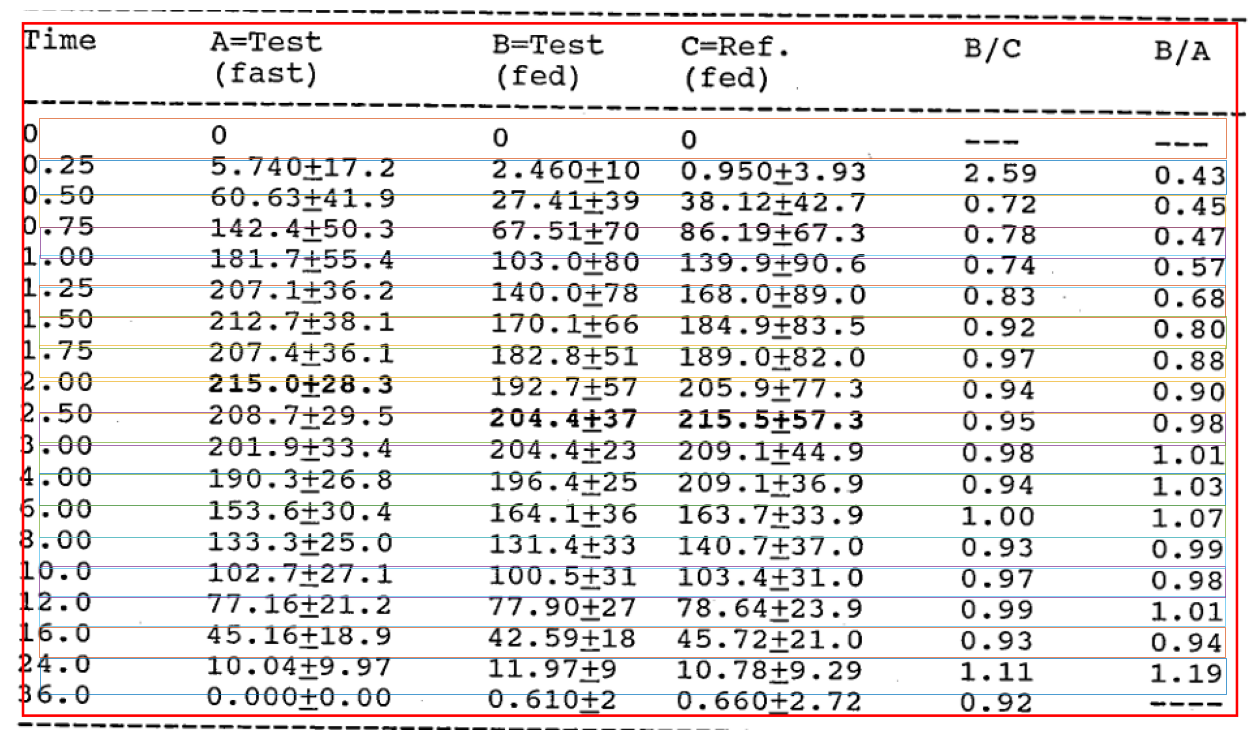

<Figure size 640x480 with 0 Axes>

In [23]:
# Let's visualise the rows first
plot_simple_box(table_images[0], table_structure_outs[0][0])

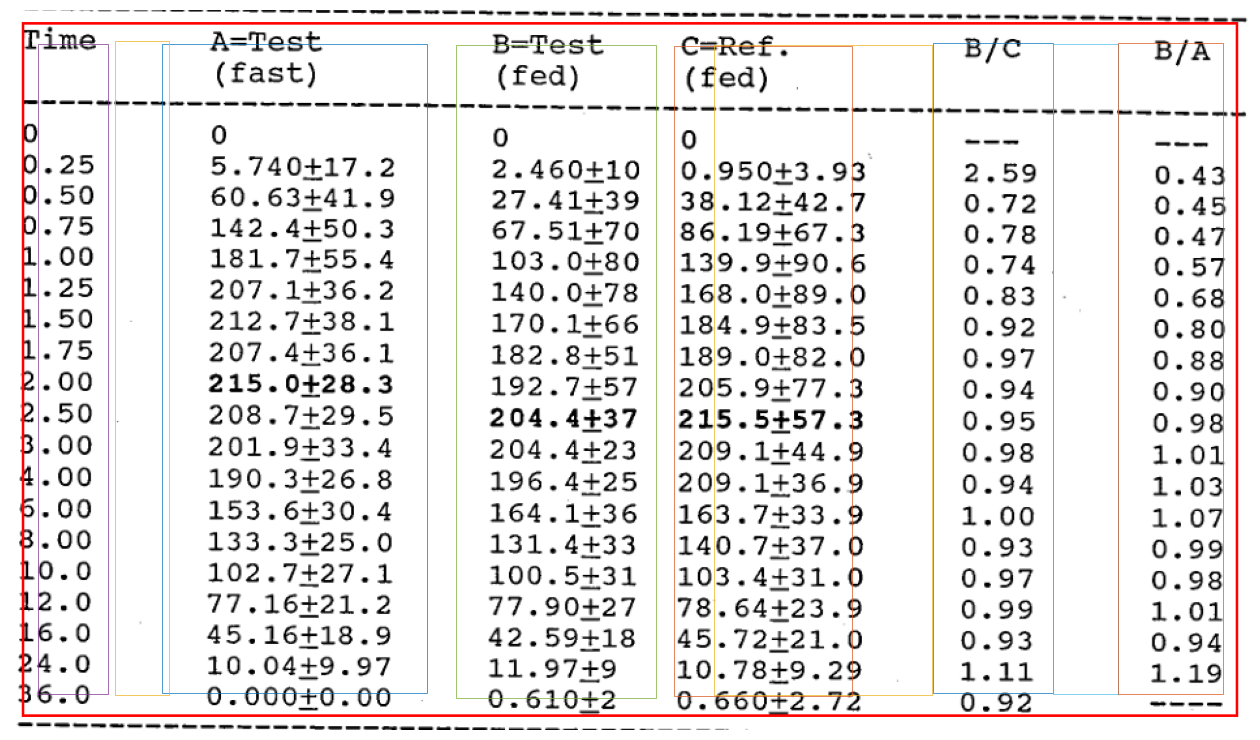

<Figure size 640x480 with 0 Axes>

In [24]:
# Let's visualise the columns
plot_simple_box(table_images[0], table_structure_outs[0][2])

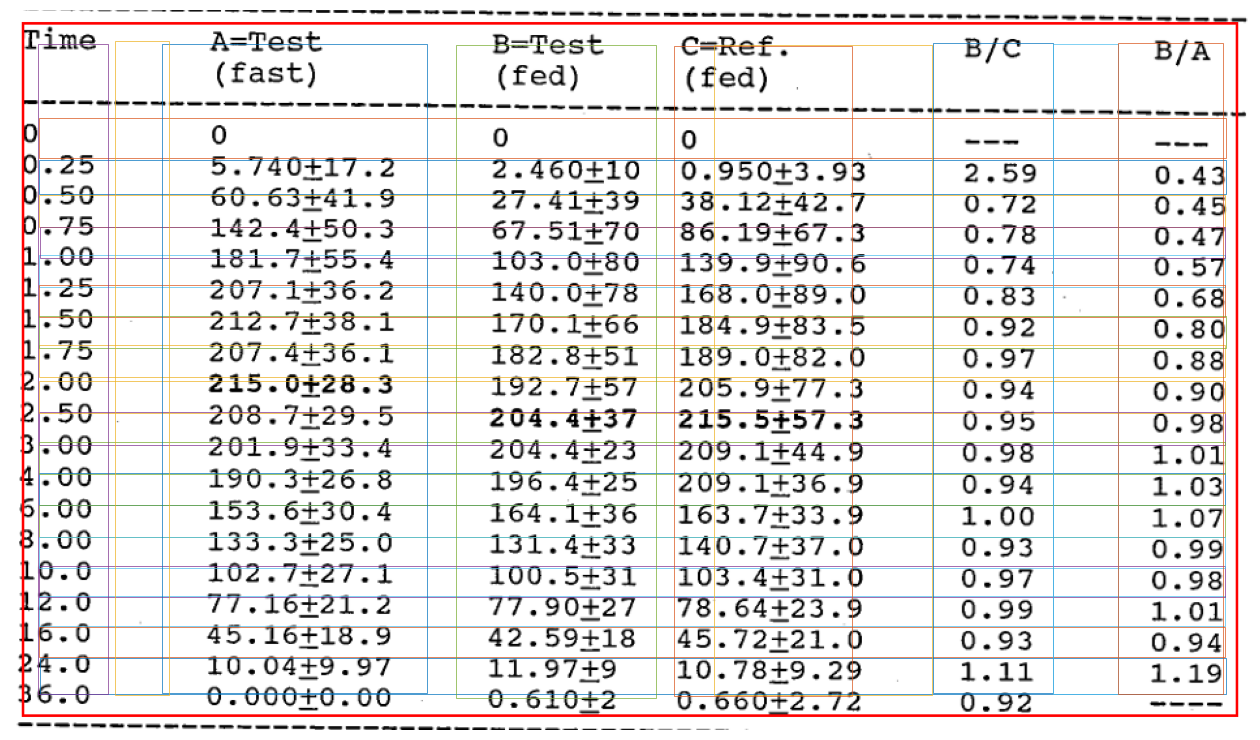

<Figure size 640x480 with 0 Axes>

In [25]:
# Let's visualise rows and columns together
plot_simple_box(table_images[0], table_structure_outs[0][0].tolist() + table_structure_outs[0][2].tolist())

## Decomposing cells

Can you write a function that takes the table_structure_outs and gives a list of cell bboxes?


In [30]:
## your function here
print(table_structure_outs[0][0].tolist())

def list_cell_boxes(row_cells, col_cells):
  cells = []
  for row_cell in row_cells:
    for col_cell in col_cells:
      cell_left_upper_x = col_cell[0]
      cell_left_upper_y = row_cell[1]
      cell_right_lower_x = col_cell[2]
      cell_right_lower_y = row_cell[3]

      cells.append([
          cell_left_upper_x,
          cell_left_upper_y,
          cell_right_lower_x,
          cell_right_lower_y
      ])
  return cells

[[21.773208618164062, 355.1626281738281, 932.053955078125, 379.58154296875], [21.720436096191406, 473.2264709472656, 932.395751953125, 496.52685546875], [21.895689010620117, 141.86830139160156, 932.5552368164062, 166.078857421875], [21.79758071899414, 308.6232604980469, 932.22802734375, 333.32147216796875], [21.747928619384766, 331.4420471191406, 932.1907958984375, 356.0955810546875], [22.089923858642578, 187.83184814453125, 932.554443359375, 212.68643188476562], [21.988265991210938, 115.20255279541016, 932.8236083984375, 140.77569580078125], [21.611263275146484, 82.54662322998047, 932.859375, 113.02784729003906], [21.729402542114258, 256.9042053222656, 932.533203125, 281.6571350097656], [22.185819625854492, 166.01956176757812, 932.3829345703125, 190.4229278564453], [21.71876335144043, 379.61798095703125, 932.2468872070312, 404.00994873046875], [21.75925064086914, 449.24493408203125, 932.4761352539062, 473.0384826660156], [22.296100616455078, 497.47137451171875, 933.0189819335938, 525.

In [31]:
cells = list_cell_boxes(table_structure_outs[0][0].tolist(), table_structure_outs[0][2].tolist())

In [32]:
cells

[[707.8219604492188, 355.1626281738281, 800.5712280273438, 379.58154296875],
 [509.04010009765625, 355.1626281738281, 646.239013671875, 379.58154296875],
 [540.066162109375, 355.1626281738281, 707.1473999023438, 379.58154296875],
 [20.63709831237793, 355.1626281738281, 74.805908203125, 379.58154296875],
 [342.2135009765625, 355.1626281738281, 495.2625427246094, 379.58154296875],
 [800.31201171875, 355.1626281738281, 850.090087890625, 379.58154296875],
 [115.83241271972656, 355.1626281738281, 319.52935791015625, 379.58154296875],
 [850.1102905273438, 355.1626281738281, 930.8451538085938, 379.58154296875],
 [80.32780456542969, 355.1626281738281, 121.73497009277344, 379.58154296875],
 [707.8219604492188, 473.2264709472656, 800.5712280273438, 496.52685546875],
 [509.04010009765625, 473.2264709472656, 646.239013671875, 496.52685546875],
 [540.066162109375, 473.2264709472656, 707.1473999023438, 496.52685546875],
 [20.63709831237793, 473.2264709472656, 74.805908203125, 496.52685546875],
 [342

In [33]:
def sort_cells(cells):
  cells.sort(key = lambda x: x[1])
  cells.sort(key = lambda x: x[0])
  return cells

In [34]:
sorted_cells = sort_cells(cells)

In [36]:
table_images[0].crop(sorted_cells[0])

## Cells to DataFrame

Now that you have each cell, what do you need to do get a DataFrame of the table with cell values?

In [37]:
%pip install paddlepaddle paddleocr
%pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.6/544.6 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 99.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.3 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=56c3

In [55]:
import cv2
from paddleocr import PaddleOCR
import numpy as np
import pandas as pd

In [43]:
ocr = PaddleOCR(use_angle_cls=True, lang='en')

[2024/10/21 15:59:45] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

In [40]:
num_rows = len(table_structure_outs[0][0].tolist())
num_cols = len(table_structure_outs[0][2].tolist())
print(num_rows, num_cols)

18 9


In [53]:
len(sorted_cells)

162

In [47]:
def pil_to_cv2(pil_image):
    return cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)

In [63]:
num_rows = len(table_structure_outs[0][0].tolist())
num_cols = len(table_structure_outs[0][2].tolist())

data = []
for i in range(num_rows):
  tmp_lst = []
  for j in range(num_cols):
    idx = i*num_cols + j
    print(idx)
    img = table_images[0].crop(sorted_cells[idx])
    img = pil_to_cv2(img)
    results = ocr.ocr(img, cls=True)
    for result in results:
      if result is None:
        tmp_lst.append(None)
      else:
        tmp_str = ""
        for result_ in result:
          tmp_str = tmp_str + result_[-1][0]
        tmp_lst.append(tmp_str)
    print(tmp_lst)
  data.append(tmp_lst)

0
[2024/10/21 16:22:31] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.015298843383789062
[2024/10/21 16:22:31] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/10/21 16:22:31] ppocr DEBUG: rec_res num  : 0, elapsed : 2.86102294921875e-06
[None]
1
[2024/10/21 16:22:31] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.018039226531982422
[2024/10/21 16:22:31] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/10/21 16:22:31] ppocr DEBUG: rec_res num  : 0, elapsed : 1.6689300537109375e-06
[None, None]
2
[2024/10/21 16:22:31] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.014565706253051758
[2024/10/21 16:22:31] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/10/21 16:22:31] ppocr DEBUG: rec_res num  : 0, elapsed : 1.6689300537109375e-06
[None, None, None]
3
[2024/10/21 16:22:31] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.014993667602539062
[2024/10/21 16:22:31] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/10/21 16:22:31] ppocr DEBUG: rec_res num  : 0, elapsed : 1.6689300537109375e-06
[None, None, None, None]
4
[202

In [64]:
data

[[None, None, None, None, '00', None, None, None, 'O0'],
 [None, 'OO', '00', None, '00', None, None, None, None],
 [None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None],
 ['0', '.40+1.', '0.63+41.', '4T30.', None, None, None, '+', '3.0+28.'],
 ['08.+',
  '201.9+3',
  '190.3+26.8',
  '153.6+30.4',
  '33.3+.',
  None,
  '77.16+21.2',
  '45.1618.9',
  '10.04+9.97'],
 ['0',
  '2.46010',
  None,
  '3+',
  '103.0+80',
  '40.0+8',
  '170.1+66',
  '182.8+51',
  None],
 ['204.4+3',
  '204.4+23',
  '196.4+25',
  '164.1+36',
  '131.4+33',
  '100.5+31',
  '77.90+27',
  '42.59+18',
  '11.979'],
 ['0',
  '0.9503.9',
  None,
  None,
  None,
  '168.0+89.',
  '184.983.',
  '189.0+82.',
  None],
 [None,
  '209.1+44.',
  '209.1+36.',
  '63.7+33.',
  '140.7+37',
  '103.4+31.',
  '78.64+23.',
  '45.72+21.',
  '10.789.2'],
 [None,
  '9503.93',
  None,
  None,
  '9+90.6',
  '8.089.0',
  '4.983.5',
  '9.082.0',
  None],
 ['.5+57.3',
  '9.144.9',
  '9.1

In [65]:
df = pd.DataFrame(data)

In [66]:
df

,0,1,2,3,4,5,6,7,8
0,None,None,None,None,00,None,None,None,O0
1,None,OO,00,None,00,None,None,None,None
2,None,None,None,None,None,None,None,None,None
3,None,None,None,None,None,None,None,None,None
4,0,.40+1.,0.63+41.,4T30.,None,None,None,+,3.0+28.
5,08.+,201.9+3,190.3+26.8,153.6+30.4,33.3+.,None,77.16+21.2,45.1618.9,10.04+9.97
6,0,2.46010,None,3+,103.0+80,40.0+8,170.1+66,182.8+51,None
7,204.4+3,204.4+23,196.4+25,164.1+36,131.4+33,100.5+31,77.90+27,42.59+18,11.979
8,0,0.9503.9,None,None,None,168.0+89.,184.983.,189.0+82.,None
9,None,209.1+44.,209.1+36.,63.7+33.,140.7+37,103.4+31.,78.64+23.,45.72+21.,10.789.2


In [67]:
df.to_csv('/content/drive/MyDrive/idp_bootcamp/week_3/week_3_assignment/csv_outs/0005ab896e95c5de6885bbf595500a8e-66.csv', index=False)

For all images

In [72]:
for i in range(len(table_images)):
  cells = list_cell_boxes(table_structure_outs[i][0].tolist(), table_structure_outs[i][2].tolist())
  sorted_cells = sort_cells(cells)

  num_rows = len(table_structure_outs[i][0].tolist())
  num_cols = len(table_structure_outs[i][2].tolist())

  data = []
  for j in range(num_rows):
    tmp_lst = []
    for k in range(num_cols):
      idx = j*num_cols + k
      print(idx)
      img = table_images[i].crop(sorted_cells[idx])
      img = pil_to_cv2(img)
      results = ocr.ocr(img, cls=True)
      for result in results:
        if result is None:
          tmp_lst.append(None)
        else:
          tmp_str = ""
          for result_ in result:
            tmp_str = tmp_str + result_[-1][0]
          tmp_lst.append(tmp_str)
      print(tmp_lst)
    data.append(tmp_lst)

  df = pd.DataFrame(data)
  df.to_csv(f'/content/drive/MyDrive/idp_bootcamp/week_3/week_3_assignment/csv_outs/{image_names[i]}.csv', index=False)

0
[2024/10/21 17:00:52] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.05953049659729004
[2024/10/21 17:00:52] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/10/21 17:00:52] ppocr DEBUG: rec_res num  : 0, elapsed : 2.86102294921875e-06
[None]
1
[2024/10/21 17:00:52] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.037061452865600586
[2024/10/21 17:00:52] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/10/21 17:00:52] ppocr DEBUG: rec_res num  : 0, elapsed : 1.9073486328125e-06
[None, None]
2
[2024/10/21 17:00:52] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.04531526565551758
[2024/10/21 17:00:52] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/10/21 17:00:52] ppocr DEBUG: rec_res num  : 0, elapsed : 1.9073486328125e-06
[None, None, None]
3
[2024/10/21 17:00:52] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.08278250694274902
[2024/10/21 17:00:52] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/10/21 17:00:52] ppocr DEBUG: rec_res num  : 0, elapsed : 2.86102294921875e-06
[None, None, None, None]
4
[2024/10/21 17: